In [13]:
# %pip install torch torchvision timm matplotlib seaborn pandas tqdm scikit-learn -q


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
import warnings
import random
import math

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")


Using MPS (Apple Silicon)
Device: mps


## В качестве датасета возьмем всем известный CIFAR-10

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
IMAGE_SIZE = 32
PATCH_SIZE = 4
NUM_CLASSES = 10

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


Train size: 50000, Test size: 10000


## Реализуем VSSD

In [16]:
class PatchEmbedding(nn.Module):
    """Разбивает изображение на патчи и проецирует в embedding space"""
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # x: (B, C, H, W) -> (B, num_patches, embed_dim)
        x = self.proj(x)  # (B, embed_dim, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        x = self.norm(x)
        return x


In [ ]:
class NonCausalSSM(nn.Module):
    def __init__(self, d_model, d_state=16, expand=2):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_inner = int(expand * d_model)
        
        self.in_proj = nn.Linear(d_model, self.d_inner * 2)
        
        self.A_log = nn.Parameter(torch.randn(self.d_inner, d_state))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        
        self.x_proj = nn.Linear(self.d_inner, d_state * 2 + 1, bias=False)
        
        self.out_proj = nn.Linear(self.d_inner, d_model)
        
        self.conv1d = nn.Conv1d(self.d_inner, self.d_inner, kernel_size=3, padding=1, groups=self.d_inner)
    
    def forward(self, x, direction='forward'):
        B, L, D = x.shape
        
        xz = self.in_proj(x)
        x, z = xz.chunk(2, dim=-1)
        
        x = x.transpose(1, 2)
        x = self.conv1d(x)
        x = x.transpose(1, 2)
        x = F.silu(x)
        
        if direction == 'backward':
            x = x.flip(1)
        
        y = self.ssm_forward(x)
        
        if direction == 'backward':
            y = y.flip(1)
        
        y = y * F.silu(z)
        y = self.out_proj(y)
        
        return y
    
    def ssm_forward(self, x):
        B, L, D = x.shape
        
        x_dbl = self.x_proj(x)  # (B, L, d_state * 2 + 1)
        delta, B_proj, C_proj = x_dbl.split([1, self.d_state, self.d_state], dim=-1)
        delta = F.softplus(delta)  # (B, L, 1)
        
        A = -torch.exp(self.A_log)  # (D, d_state)
        
        y = self.parallel_scan(x, delta, A, B_proj, C_proj)
        
        y = y + x * self.D.unsqueeze(0).unsqueeze(0)
        
        return y
    
    def parallel_scan(self, x, delta, A, B_proj, C_proj):
        B_batch, L, D = x.shape
        d_state = self.d_state
        
        B_mod = B_proj * delta  # (B, L, d_state)
        
        weights = torch.einsum('bls,bks->blk', B_mod, C_proj)  # (B, L, L)
        weights = F.softmax(weights / math.sqrt(d_state), dim=-1)
        
        y = torch.einsum('blk,bkd->bld', weights, x)
        
        return y


In [ ]:
class VSSDBlock(nn.Module):
    def __init__(self, dim, d_state=16, expand=2, drop_path=0.0):
        super().__init__()
        self.dim = dim
        self.norm = nn.LayerNorm(dim)
        
        self.ssm = NonCausalSSM(dim, d_state, expand)
        self.drop_path = nn.Identity() if drop_path == 0 else nn.Dropout(drop_path)
    
    def forward(self, x):
        # x: (B, L, D)
        residual = x
        x = self.norm(x)
        
        x_forward = self.ssm(x, direction='forward')
        x_backward = self.ssm(x, direction='backward')
        
        x = (x_forward + x_backward) / 2
        
        x = self.drop_path(x) + residual
        return x


In [ ]:
class VSSD(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=192, depth=6, d_state=16, expand=2, drop_path=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(0.1)
        
        dpr = [x.item() for x in torch.linspace(0, drop_path, depth)]
        self.blocks = nn.ModuleList([
            VSSDBlock(embed_dim, d_state, expand, dpr[i])
            for i in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        
        return x


## В качестве baseline модели возьмем простой ViT

In [ ]:
class SimpleViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=192, depth=6, num_heads=6, mlp_ratio=4.0, drop_rate=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=drop_rate,
            activation='gelu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
    
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        x = self.encoder(x)
        
        x = self.norm(x[:, 0])
        x = self.head(x)
        
        return x


## Заведем функции обучения и оценки


In [21]:
def train_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(train_loader), correct / total


def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
    }
    
    return metrics, all_preds, all_labels


In [ ]:
def train_model(model, train_loader, test_loader, num_epochs, lr, device, model_name):
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    
    total_steps = len(train_loader) * num_epochs
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)
    
    history = {'train_loss': [], 'train_acc': [], 'test_acc': [], 'test_f1': []}
    
    print(f"\n{'='*60}\nОбучение модели: {model_name}\n{'='*60}")
    print(f"Параметров: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)
        metrics, _, _ = evaluate(model, test_loader, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(metrics['accuracy'])
        history['test_f1'].append(metrics['f1_macro'])
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Test Acc: {metrics['accuracy']:.4f}, Test F1: {metrics['f1_macro']:.4f}")
    
    final_metrics, final_preds, final_labels = evaluate(model, test_loader, device)
    print(f"\nФинальные результаты ({model_name}):")
    print(f"  Accuracy: {final_metrics['accuracy']:.4f}, F1: {final_metrics['f1_macro']:.4f}")
    
    return model, history, (final_metrics, final_preds, final_labels)


## И наконец само обучение

In [ ]:
vssd_model = VSSD(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_classes=NUM_CLASSES,
    embed_dim=192,
    depth=6,
    d_state=16,
    expand=2,
    drop_path=0.1
)

vssd_model, vssd_history, vssd_results = train_model(
    vssd_model, train_loader, test_loader,
    num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device, model_name="VSSD"
)


Обучение модели: VSSD
Параметров: 1,483,978

Epoch 1/10


Train Loss: 1.6703, Train Acc: 0.3776
Test Acc: 0.4558, Test F1: 0.4416

Epoch 2/10


Train Loss: 1.2626, Train Acc: 0.5394
Test Acc: 0.5789, Test F1: 0.5728

Epoch 3/10


Train Loss: 1.0633, Train Acc: 0.6164
Test Acc: 0.6330, Test F1: 0.6311

Epoch 4/10


Train Loss: 0.9412, Train Acc: 0.6635
Test Acc: 0.6840, Test F1: 0.6855

Epoch 5/10


Train Loss: 0.8436, Train Acc: 0.7003
Test Acc: 0.6920, Test F1: 0.6917

Epoch 6/10


Train Loss: 0.7627, Train Acc: 0.7290
Test Acc: 0.7307, Test F1: 0.7272

Epoch 7/10


Train Loss: 0.6953, Train Acc: 0.7510
Test Acc: 0.7444, Test F1: 0.7422

Epoch 8/10


Train Loss: 0.6447, Train Acc: 0.7718
Test Acc: 0.7526, Test F1: 0.7501

Epoch 9/10


Train Loss: 0.6128, Train Acc: 0.7830
Test Acc: 0.7611, Test F1: 0.7604

Epoch 10/10


Train Loss: 0.5950, Train Acc: 0.7914
Test Acc: 0.7617, Test F1: 0.7608



Финальные результаты (VSSD):
  Accuracy: 0.7617, F1: 0.7608


In [ ]:
vit_model = SimpleViT(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_classes=NUM_CLASSES,
    embed_dim=192,
    depth=6,
    num_heads=6,
    drop_rate=0.1
)

vit_model, vit_history, vit_results = train_model(
    vit_model, train_loader, test_loader,
    num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device, model_name="ViT"
)



Обучение модели: ViT
Параметров: 2,693,962

Epoch 1/10


Train Loss: 1.8685, Train Acc: 0.2880
Test Acc: 0.3566, Test F1: 0.3389

Epoch 2/10


Train Loss: 1.5746, Train Acc: 0.4116
Test Acc: 0.4607, Test F1: 0.4584

Epoch 3/10


Train Loss: 1.3886, Train Acc: 0.4930
Test Acc: 0.5159, Test F1: 0.5026

Epoch 4/10


Train Loss: 1.2505, Train Acc: 0.5492
Test Acc: 0.5901, Test F1: 0.5836

Epoch 5/10


Train Loss: 1.1279, Train Acc: 0.5949
Test Acc: 0.6221, Test F1: 0.6136

Epoch 6/10


Train Loss: 1.0308, Train Acc: 0.6299
Test Acc: 0.6584, Test F1: 0.6534

Epoch 7/10


Train Loss: 0.9403, Train Acc: 0.6638
Test Acc: 0.6819, Test F1: 0.6775

Epoch 8/10


Train Loss: 0.8661, Train Acc: 0.6931
Test Acc: 0.7040, Test F1: 0.7018

Epoch 9/10


Train Loss: 0.8116, Train Acc: 0.7110
Test Acc: 0.7119, Test F1: 0.7090

Epoch 10/10


Train Loss: 0.7876, Train Acc: 0.7184
Test Acc: 0.7165, Test F1: 0.7131



Финальные результаты (ViT):
  Accuracy: 0.7165, F1: 0.7131


## 6. Визуализация результатов


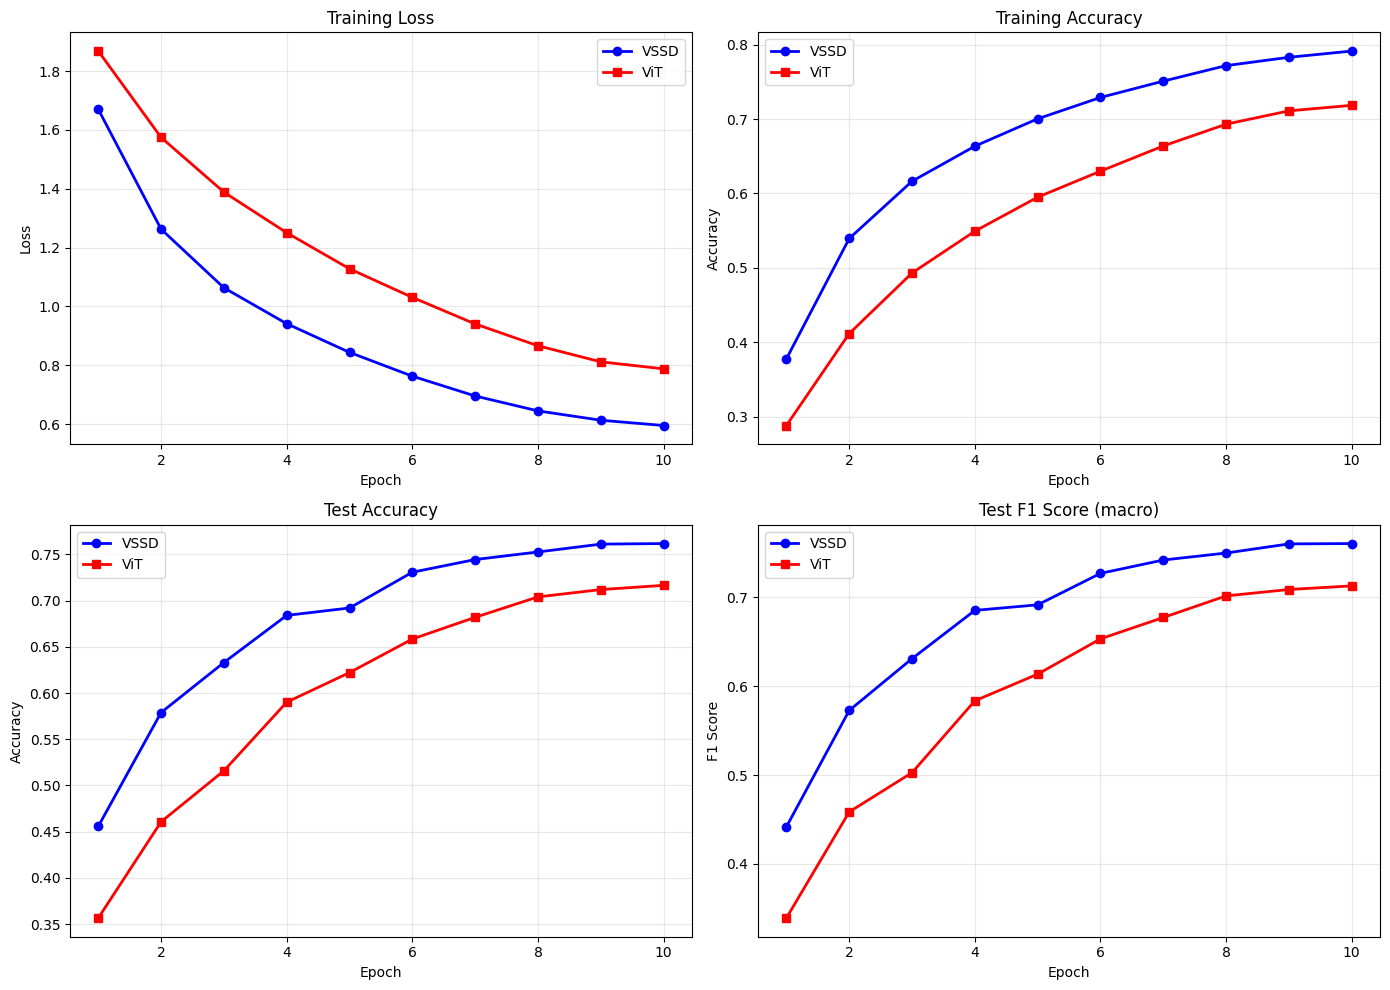

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs = range(1, NUM_EPOCHS + 1)

# Training Loss
ax = axes[0, 0]
ax.plot(epochs, vssd_history['train_loss'], 'b-o', label='VSSD', linewidth=2)
ax.plot(epochs, vit_history['train_loss'], 'r-s', label='ViT', linewidth=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.set_title('Training Loss')
ax.legend(); ax.grid(True, alpha=0.3)

# Training Accuracy
ax = axes[0, 1]
ax.plot(epochs, vssd_history['train_acc'], 'b-o', label='VSSD', linewidth=2)
ax.plot(epochs, vit_history['train_acc'], 'r-s', label='ViT', linewidth=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy'); ax.set_title('Training Accuracy')
ax.legend(); ax.grid(True, alpha=0.3)

# Test Accuracy
ax = axes[1, 0]
ax.plot(epochs, vssd_history['test_acc'], 'b-o', label='VSSD', linewidth=2)
ax.plot(epochs, vit_history['test_acc'], 'r-s', label='ViT', linewidth=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy'); ax.set_title('Test Accuracy')
ax.legend(); ax.grid(True, alpha=0.3)

# Test F1
ax = axes[1, 1]
ax.plot(epochs, vssd_history['test_f1'], 'b-o', label='VSSD', linewidth=2)
ax.plot(epochs, vit_history['test_f1'], 'r-s', label='ViT', linewidth=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('F1 Score'); ax.set_title('Test F1 Score (macro)')
ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Выводы

 - VSSD превосходит ViT на +4.5% accuracy при почти вдвое меньшем числе параметров
    - Скорость сходимости при этом примерно одинаковая 
 - Эксперимент подтверждает, что SSM-архитектуры хорошая альтернатива Transformer для CV задач